<a href="https://colab.research.google.com/github/yandexdataschool/MLatImperial2022/blob/main/Seminars/lab_04_ensembles%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision trees, ensembling and model selection

In [7]:
import numpy as np
import matplotlib.pyplot as plt

Let's generate a toy dataset:

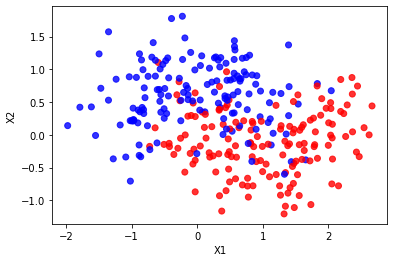

In [8]:
from sklearn.datasets import make_blobs,make_moons

X_toy, y_toy = make_moons(n_samples=300, shuffle=True, noise=0.4, random_state=10)

#make_blobs(n_samples=400,                          centers=[[0., 1.], [1., 2.]],                          random_state=14)

plt.scatter(X_toy[:, 0], X_toy[:, 1], c=y_toy, alpha=0.8, cmap='bwr')
plt.xlabel('X1'), plt.ylabel('X2');

## Decision trees out of the box

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

DecisionTreeClassifier has a number of parameters:
* `max_depth` – a limit on tree depth (default – no limit)
* `min_samples_split` – there should be at least this many samples to split further (default – 2)
* `min_samples_leaf` – there should be at least this many samples on one side of a split to consider it valid (default – 1).
* `criterion` – 'gini' or 'entropy' – split stuff over this parameter (default : gini)

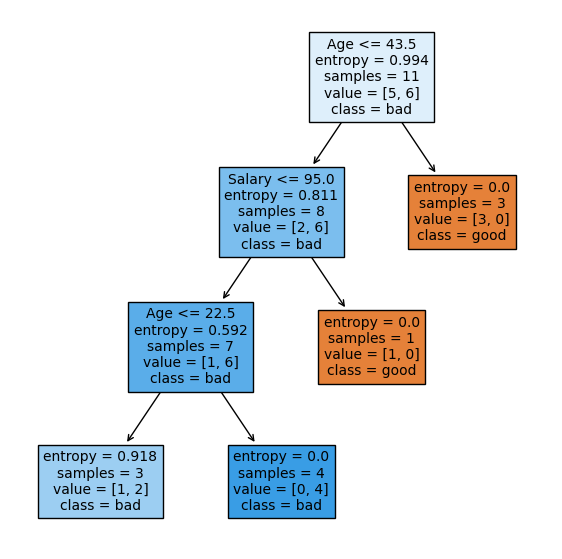

In [10]:
import pandas as pd
data2 = pd.DataFrame({'Age':  [17,64,18,20,38,49,55,25,29,31,33],
                      'Salary': [25,80,22,36,37,59,74,70,33,102,88],
                      'Loan Default': [1,0,1,0,1,0,0,1,1,0,1]})
data2.sort_values('Age')

age_sal_tree = DecisionTreeClassifier(criterion='entropy',max_depth=3,random_state=17)
age_sal_tree.fit(data2[['Age', 'Salary']].values, data2['Loan Default'].values)
from sklearn import tree
import  matplotlib.pyplot as plt 
import seaborn as sns
sns.reset_defaults()
plt.figure(figsize=(7, 7))
tree.plot_tree(age_sal_tree,filled=True,fontsize=10,feature_names = ['Age', 'Salary'],class_names=['good','bad'])
plt.show()

In [11]:
clf = DecisionTreeClassifier(min_samples_leaf=15)
clf.fit(X_toy, y_toy)

DecisionTreeClassifier(min_samples_leaf=15)

### Plot decision surface

Here's a function that makes a 2d decision boundary plot for a given classifier:

In [12]:
from sklearn.metrics import accuracy_score

def plot_decision_surface(
                  clf, X, y,
                  grid_step=0.02,
                  cmap='bwr',
                  alpha=0.6,
        ):
    """
    Plot the decision boundary of clf on X and y, visualize training points
    """
    
    # Define the grid
    x_top_left = X.min(axis=0) - 1
    x_bottom_right = X.max(axis=0) + 1
    grid_x0, grid_x1 = np.meshgrid(
         np.arange(x_top_left[0], x_bottom_right[0], grid_step),
         np.arange(x_top_left[1], x_bottom_right[1], grid_step)
      )
    
    # Calculate predictions on the grid
    y_pred_grid = clf.predict(
                        np.stack(
                              [
                                grid_x0.ravel(),
                                grid_x1.ravel()
                              ],
                              axis=1
                            )
                      ).reshape(grid_x1.shape)
    
    # Find optimal contour levels and make a filled
    # contour plot of predictions
    labels = np.sort(np.unique(y))
    labels = np.concatenate([[labels[0] - 1],
                             labels,
                             [labels[-1] + 1]])
    medians = (labels[1:] + labels[:-1]) / 2
    plt.contourf(grid_x0, grid_x1, y_pred_grid, cmap=cmap, alpha=alpha,
                 levels=medians)
    
    # Scatter data points on top of the plot,
    # with different styles for correct and wrong
    # predictions
    y_pred = clf.predict(X)
    plt.scatter(*X[y_pred==y].T, c=y[y_pred==y],
                marker='o', cmap=cmap, s=10, label='correct')
    plt.scatter(*X[y_pred!=y].T, c=y[y_pred!=y],
                marker='x', cmap=cmap, s=50, label='errors')

    # Dummy plot call to print the accuracy in the legend.
    plt.plot([], [], ' ',
             label='Accuracy = {:.3f}'.format(accuracy_score(y, y_pred)))
    
    plt.legend(loc='best')
    
    

Let's apply it to the tree we've fitted above:

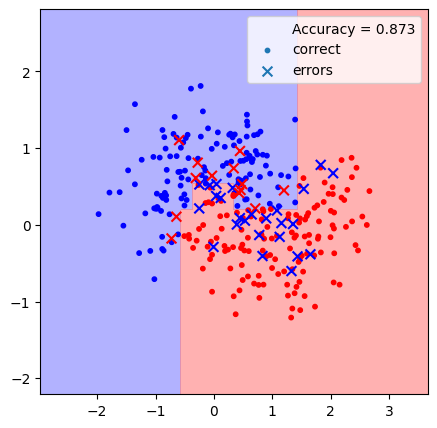

In [13]:
plt.figure(figsize=(5, 5))
plot_decision_surface(clf, X_toy, y_toy)

### Tree depth

First we are going to split our data to train and test subsets:

In [14]:
X_train, X_test, y_train, y_test = \
    train_test_split(X_toy, y_toy, test_size=0.25)

Now it's your turn to investigate how the decision boundary depends on the tree depth. Maximum tree depth is defined by the `max_depth` parameter. Try out the following values: `[1, 2, 3, 5, 10]`. Make decision boundary plots for both train and test datasets (separately).

  > *Hint: you can make a nice plot with multiple columns and rows (see example below).*
  
```python
plt.figure(figsize=(width, height))
for i in range(num_rows):
  for j in range(num_columns):
    plt.subplot(num_rows, num_columns, i * num_columns + j + 1)
    # subplot numbering starts from 1                       ^^^
    
    # ...
    # (do the plotting for plot i, j)
plt.show();
```

In [15]:
#X_toy_train[:,0]=X_toy_train[:,0]/5
#X_toy_test[:,0]=X_toy_test[:,0]/5

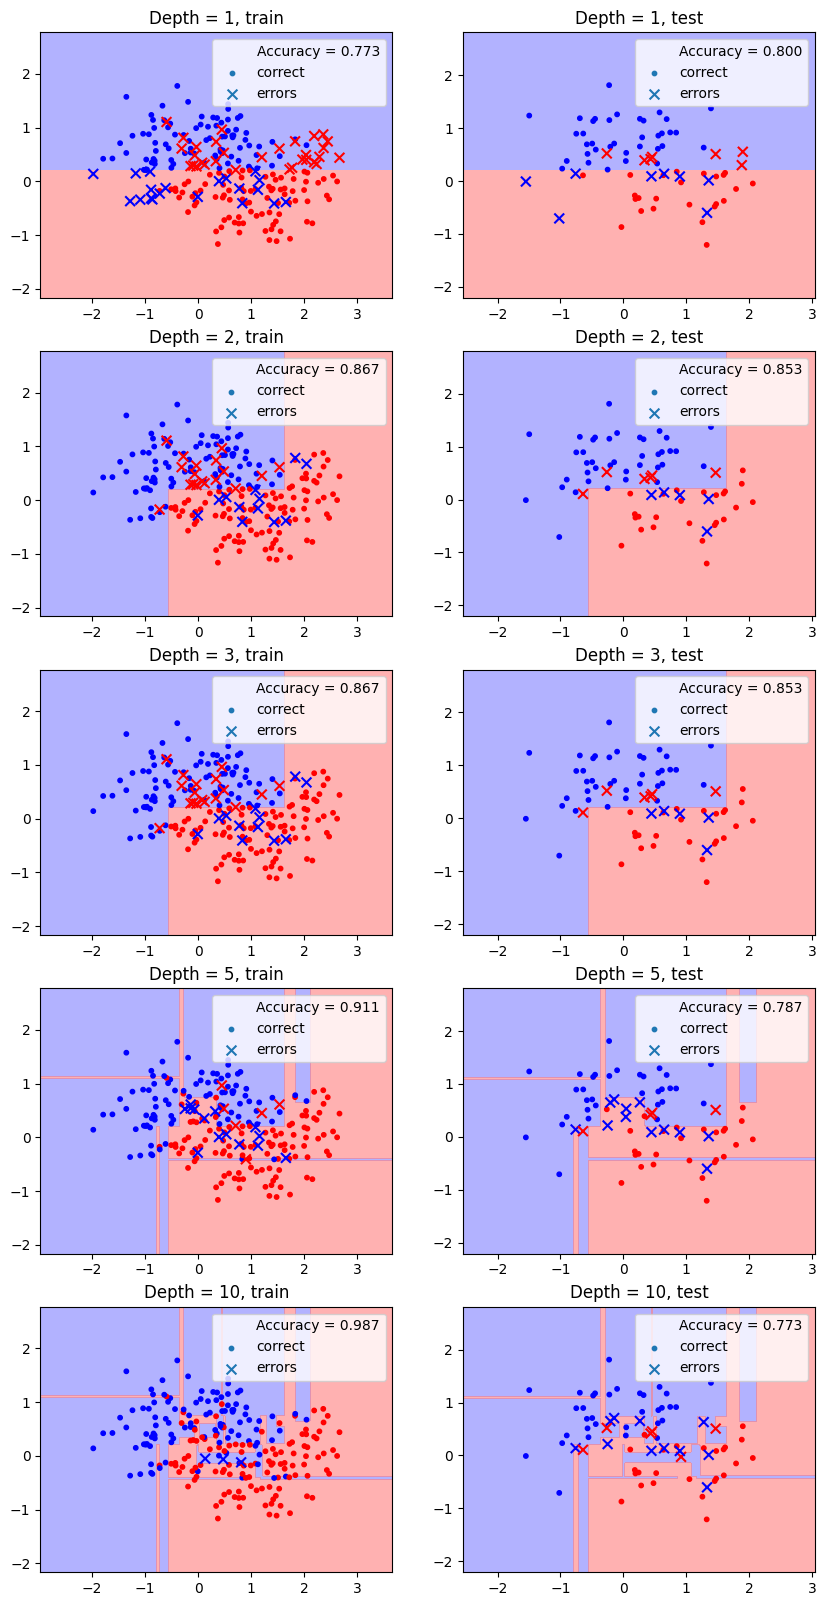

In [16]:
depth_values = [1, 2, 3, 5, 10]

plt.figure(figsize=(10, 20))
plt.axis('auto')
for i, depth in enumerate(depth_values):
    clf = DecisionTreeClassifier(max_depth=depth)
    clf.fit(X_train, y_train)

    plt.subplot(len(depth_values), 2, 2 * i + 1)
    plot_decision_surface(clf, X_train, y_train)
    plt.title(f"Depth = {depth}, train")

    plt.subplot(len(depth_values), 2, 2 * i + 2)
    plot_decision_surface(clf, X_test, y_test)
    plt.title(f"Depth = {depth}, test")
  

In [17]:
#Question: Do desision trees depend on features scaling? ()

#### Instability of Decision Trees
Decision trees are algorithms that are unstable to changes in the training sample, i.e. at its slightest changes, the final classifier can change radically. Let's see how the structure of the tree will change when training on different 90% subsamples.

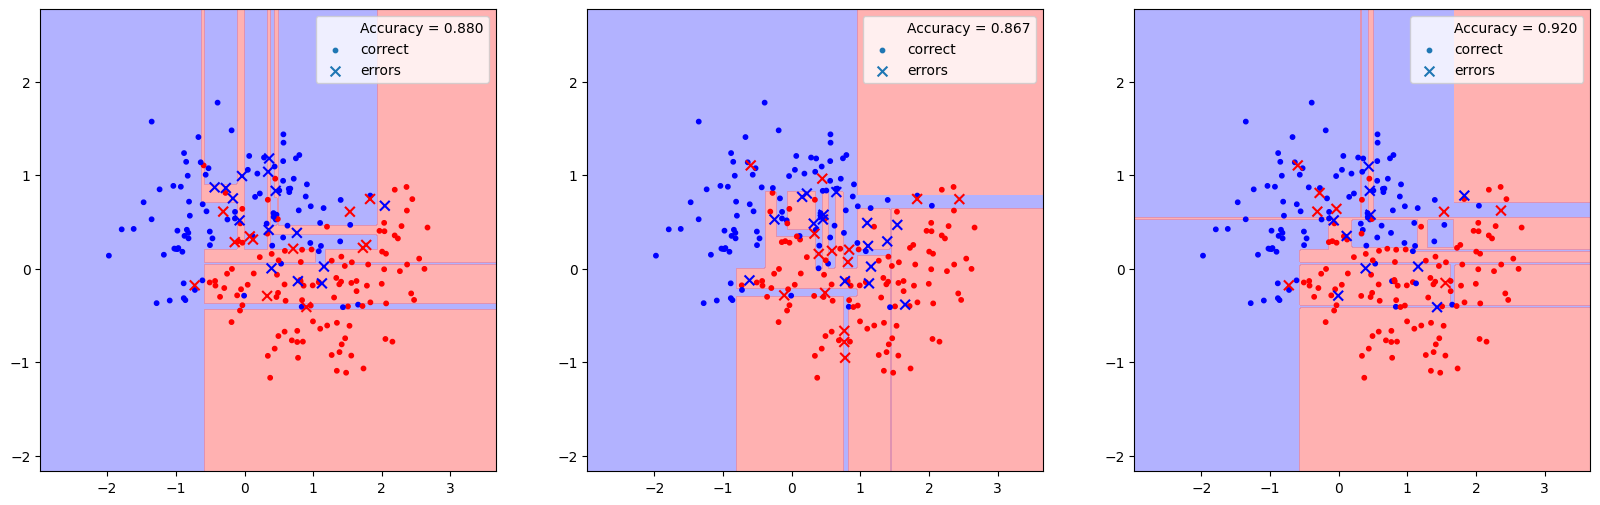

In [18]:
plt.figure(figsize=(20, 6))
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

for i in range(3):
    clf = DecisionTreeClassifier(random_state=10)
    indecies = np.random.randint(X_train.shape[0], size=int(X_train.shape[0] * 0.9))
    clf.fit(X_train[indecies], y_train[indecies])
    plt.subplot2grid((1, 3), (0, i))
    plot_decision_surface(clf, X_train, y_train)


## Notes on Decision Tree:

- independent on features scale
- during classification decision tree returns probability
- pre-stopping matters (`max_depth`, `min_samples_leaf`)

## Decision Tree for regression

In [19]:
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(min_samples_leaf=20)
tree_reg.fit(X_train, y_train) # build a tree
predicted_test_grades = tree_reg.predict(X_test)
print(mean_squared_error(y_test, predicted_test_grades))

0.13725117239523668


### Plotting decision rules

decision rule is piecewise-constant

In [20]:
# Create a random dataset. This is the way to get repropducible 
rng = np.random.RandomState(1)
X_toyreg = np.sort(5 * rng.rand(80, 1), axis=0)
y_toyreg = np.sin(X_toyreg).ravel() + rng.laplace(size=80) * 0.2

In [21]:
plt.figure(figsize=(4, 4))
def plot_regressor_decision(regressor, X, y, margin=0.1):
    plt.scatter(X[:, 0], y, c='b', s=20)
    x_range = X[:, 0].min() - margin, X[:, 0].max() + margin
    x_values = np.linspace(*x_range, num=200)
    plt.plot(x_values, regressor.predict(x_values[:, None]), 'g')
    plt.xlim(*x_range)


<Figure size 400x400 with 0 Axes>

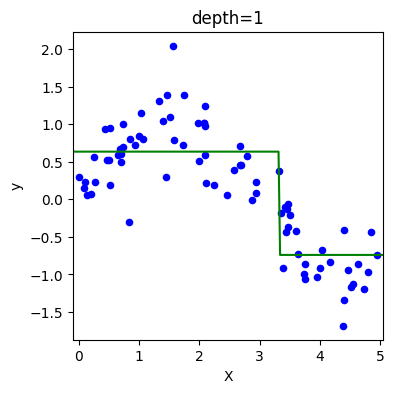

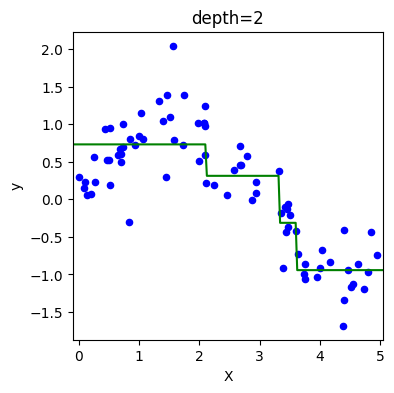

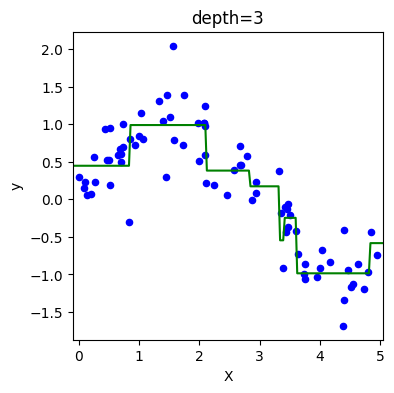

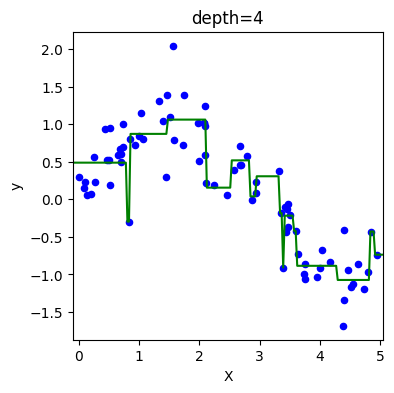

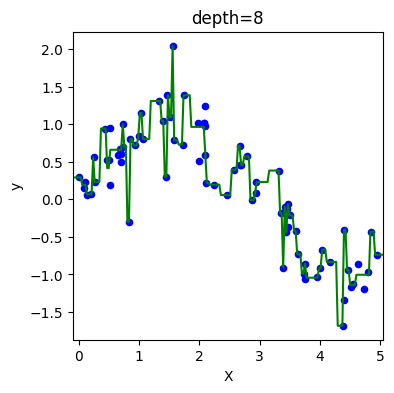

In [22]:

for i,depth in enumerate([1, 2, 3, 4, 8]):
    plt.figure(figsize=(4, 4))
    tree_reg = DecisionTreeRegressor(max_depth=depth).fit(X_toyreg, y_toyreg)
    plot_regressor_decision(tree_reg, X_toyreg, y_toyreg)
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title(f'depth={depth}')
    plt.show()

# Ensembles

Let's build our own decision tree bagging and see how well it works. Implement the **`BagOfTrees`** class below:

In [23]:
class BagOfTrees:
    def __init__(self, n_estimators=10, **kwargs):
        self.trees = []
        for i in range(n_estimators):
            self.trees.append(DecisionTreeClassifier(**kwargs))
        
    def fit(self, X, y):
        trees = self.trees
    
    # Fit each of the trees on a random subset of X and y.
    # hint: you can select random subsample of data like this:
    # >>> ix = np.random.randint(0, len(X), len(X))
    # >>> X_sample, y_sample = X[ix], y[ix]

        for tree in trees:
            ix = np.random.randint(0, len(X), len(X))
            X_sample, y_sample = X[ix], y[ix]
            tree.fit(X_sample, y_sample)

    
    def predict(self, X):
        trees = self.trees
    
    # Compute predictions of each tree and aggregate them into
    # the ensemble prediction
    # Note: you can use tree.predict(X) to get the predicted classes
    # or tree.predict_proba(X) to get individual probabilities
    # for all classes

        probs = np.array([tree.predict_proba(X) for tree in trees])
        avg_probs = probs.mean(axis=0)
        return np.argmax(avg_probs, axis=1)

  


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_toy, y_toy, test_size=0.25)
model = BagOfTrees(n_estimators=100, min_samples_leaf=3)
model.fit(X_train, y_train)


In [25]:
for i, tree in enumerate(model.trees[:5]):
    print("tree {} individual accuracy = {:.5f}".format(
        i, accuracy_score(y_test, tree.predict(X_test))
      ))

print("Ensemble accuracy:",
      accuracy_score(y_test, model.predict(X_test))) # should be >= 0.78

tree 0 individual accuracy = 0.78667
tree 1 individual accuracy = 0.82667
tree 2 individual accuracy = 0.78667
tree 3 individual accuracy = 0.81333
tree 4 individual accuracy = 0.80000
Ensemble accuracy: 0.84


And have a look at the decision surface:

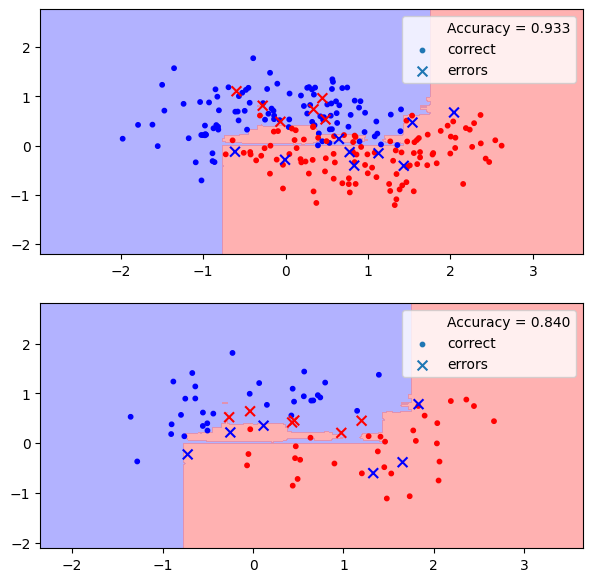

In [26]:
plt.figure(figsize=(7, 7))
plt.subplot(2, 1, 1)
plot_decision_surface(model, X_train, y_train, cmap='bwr', grid_step=0.02)
plt.subplot(2, 1, 2)
plot_decision_surface(model, X_test, y_test, cmap='bwr', grid_step=0.02);

Now let's check how train and test accuracy depends on the number of estimators.

Hint: instead of fitting a new BagOfTrees for each number of estimators we can just fit the maximum number and then iteratively predict and remove the fitted trees one by one.

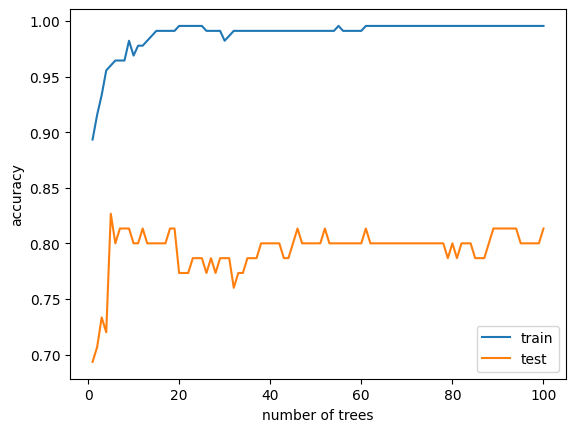

In [27]:
model = BagOfTrees(n_estimators=100, min_samples_split=3, splitter='random', random_state=42)
model.fit(X_train, y_train)

n_trees = []
test_score = []
train_score = []

while len(model.trees) > 0: 
    n_trees.append(len(model.trees))
    train_score.append(accuracy_score(y_train, model.predict(X_train)))
    test_score.append(accuracy_score(y_test, model.predict(X_test)))
    model.trees.pop()

plt.plot(n_trees, train_score, label='train')
plt.plot(n_trees, test_score, label='test')
plt.legend()
plt.xlabel('number of trees')
plt.ylabel('accuracy');

## Random Forest 

Builds independently many trees. 

Each tree is trained on a part of training data obtained by 
- sampling features (columns) without replacements (**Random Subspace Model**)
- sampling events (rows) with replacement (**bagging**)

In [28]:
from sklearn.ensemble import  RandomForestClassifier

RandomForest combines bagging and random subspaces: each tree uses a fraction of training samples, and the splits are chosen among subsets of features. Typically this leads to a slightly better performance.


For random forest in sklearn the class is implemented

sklearn.ensemble.RandomForestRegressor(n_estimators=100, ...)
    parameter values:
    
    - max_samples: the main bagging parameter, determines the proportion or number of objects in the training sample in each 'batch' of objects for training the base_estimator algorithm
       
    - bootstrap: if True, a random selection is made with the object returned to the selection pool, otherwise no return
    - max_features: needed to implement the random subspace method, we pass a fraction or a natural number of sampled features (default 1).


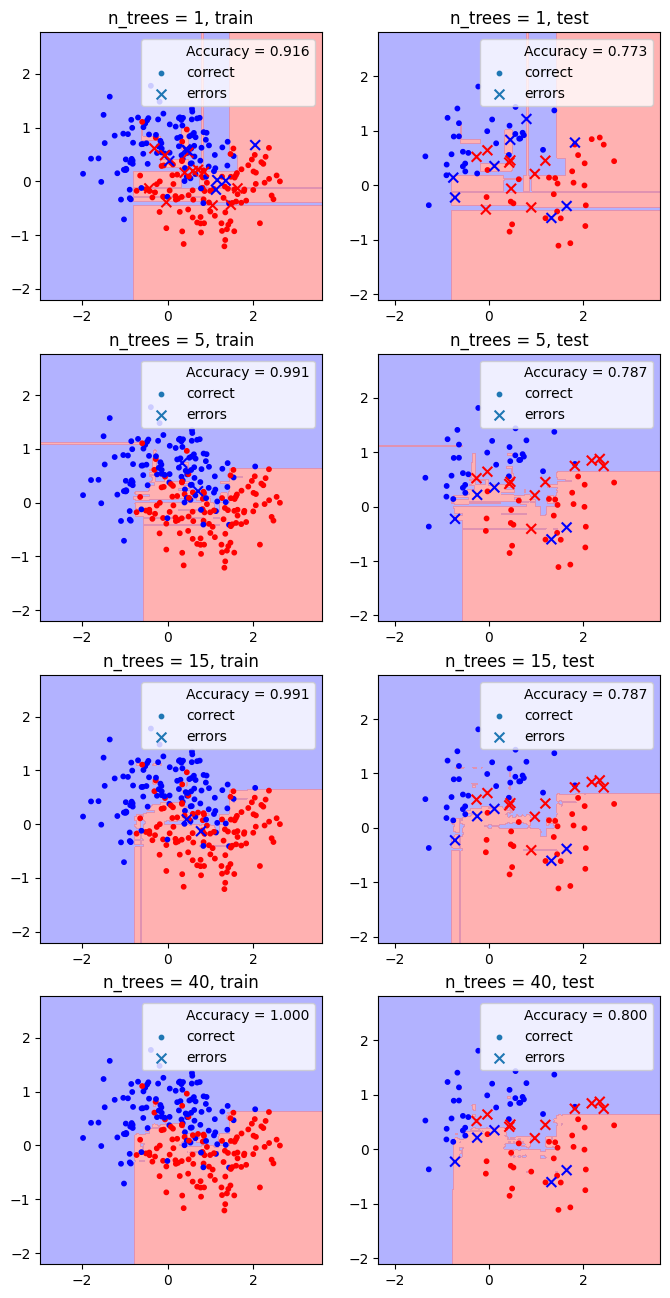

In [29]:
depth_values = [1, 5, 15, 40]

plt.figure(figsize=(8, 16))
plt.axis('auto')
for i, n_trees in enumerate(depth_values):
    clf = RandomForestClassifier(n_estimators=n_trees)
    clf.fit(X_train, y_train)

    plt.subplot(len(depth_values), 2, 2 * i + 1)
    plot_decision_surface(clf, X_train, y_train)
    plt.title(f"n_trees = {n_trees}, train")

    plt.subplot(len(depth_values), 2, 2 * i + 2)
    plot_decision_surface(clf, X_test, y_test)
    plt.title(f"n_trees = {n_trees}, test")
  

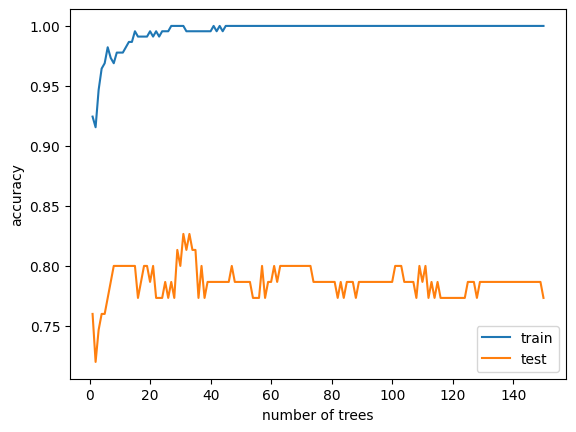

In [30]:
model = RandomForestClassifier(n_estimators=150)
model.fit(X_train, y_train)

n_trees = []
test_score = []
train_score = []

while len(model.estimators_) > 0: # fill the lists above to make the plot
    n_trees.append(len(model.estimators_))
    train_score.append(accuracy_score(y_train, model.predict(X_train)))
    test_score.append(accuracy_score(y_test, model.predict(X_test)))
    model.estimators_.pop()

plt.plot(n_trees, train_score, label='train')
plt.plot(n_trees, test_score, label='test')
plt.legend()
plt.xlabel('number of trees')
plt.ylabel('accuracy');

RandomForest combines bagging and random subspaces: each tree uses a fraction of training samples, and the splits are chosen among subsets of features. Typically this leads to a slightly better performance.

For next example we are going to use California Housing Dataset.

The **target** variable is the median house value for California districts.


The features are:
 *   **MedInc** median income in block
 *   **HouseAge** median house age in block
 *   **AveRooms** average number of rooms
 *   **AveBedrms** average number of bedrooms
 *   **Population** block population
 *   **AveOccup** average house occupancy
 *   **Latitude** house block latitude
 *   **Longitude** house block longitude
 
 More information [here](https://scikit-learn.org/stable/datasets/index.html#california-housing-dataset).

In [31]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

In [32]:
dataset = fetch_california_housing()

`dataset` holds the data in numpy arrays, but we can convert it to a pandas dataframe:

In [33]:
data = pd.DataFrame(dataset.data, columns=dataset.feature_names).drop("MedInc", axis=1)
data['target'] = dataset.target

data.head(10)

,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


Now, let's separate the features from the target and split the data to train and test parts:

In [34]:
data_X = data.drop('target', axis=1)
data_y = data['target']

X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, train_size=0.2) 

In [35]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4128, 7), (16512, 7), (4128,), (16512,))

and grid search for best random forest parameters on it:

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor(n_estimators=30)

gscv = GridSearchCV(model,
                    param_grid={'max_depth' : [1, 5, 10, 20],
                                "min_samples_split" : [2, 10, 20]},
                    scoring='neg_mean_squared_error',
                    n_jobs=-1,
                    cv=3,
                    verbose=3)

gscv.fit(X_train, y_train)
model = gscv.best_estimator_
print(model)

print("Train loss:", mean_squared_error(y_train, model.predict(X_train)))
print("Test loss:" , mean_squared_error(y_test , model.predict(X_test )))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
RandomForestRegressor(max_depth=20, min_samples_split=10, n_estimators=30)
Train loss: 0.10400097268168657
Test loss: 0.32110180240484265


RandomForest combines bagging and random subspaces: each tree uses a fraction of training samples, and the splits are chosen among subsets of features. Typically this leads to a slightly better performance.

Transform target and  some other fields

In [37]:
gscv.best_params_

{'max_depth': 20, 'min_samples_split': 10}

In [38]:
!wget -N https://raw.githubusercontent.com/yandexdataschool/MLatImperial2022/main/Seminars/utility.py

--2022-01-28 16:49:09--  https://raw.githubusercontent.com/yandexdataschool/MLatImperial2022/main/Seminars/utility.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9389 (9.2K) [text/plain]
Saving to: ‘utility.py’

utility.py          100%[===================>]   9.17K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2022-01-28 16:49:10 (91.6 MB/s) - ‘utility.py’ saved [9389/9389]



In [39]:
from utility import show_param_dependency

show_param_dependency(rf, X_train, y_train, X_test, y_test, param_name='n_estimators', 
     
                      loss_fun='MSE', param_vals=np.arange(1,300,30), x_label='K')

NameError: ignored

###  Gradient Boosting in sklearn

Check out [this nice demo](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) on the gradient boosting.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
gradient boosting parameters:

we can vary:

- loss {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'
- learning_rate : limits the contribution of each subsequent tree
- subsample - share of the training sample that each base learner receives
- max_depth ( default=3), you can decrease and get deg.boosting of decisive stumps
- max_features (number of randomly selected features per split)
- warm_start - when re-running fit() adds new base-learners to the previous model fit
- n_iter_no_change - stops training if there were no n_iter_no_change times in a row to improve loss (on the validation part, there is also a parameter)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn import datasets

original_params = {
    "n_estimators": 500,
    "max_leaf_nodes": 4,
    "max_depth": None,
    "random_state": 2,
    "min_samples_split": 5,
}

plt.figure(figsize=(7,7))

for label, color, setting in [
   
    ("learning_rate=0.1", "turquoise", {"learning_rate": 0.1, "subsample": 1.0}),
    ("learning_rate=0.5 subsample=0.5", "blue", {"learning_rate": 0.5, "subsample": 0.5}),
    (
        "learning_rate=0.1, subsample=0.5",
        "gray",
        {"learning_rate": 0.1, "subsample": 0.5},
    ),
    (
        "learning_rate=0.1, max_features=2",
        "magenta",
        {"learning_rate": 0.1, "max_features": 2},
    ),
]:
    params = dict(original_params)
    params.update(setting)

    clf = GradientBoostingRegressor(**params)
    clf.fit(X_train, y_train)

    # compute test set deviance
    test_deviance = np.zeros((params["n_estimators"],), dtype=np.float64)

    for i, y_pred in enumerate(clf.staged_predict(X_test)):
        # clf.loss_ assumes that y_test[i] in {0, 1}
        test_deviance[i] = mean_squared_error(y_test, y_pred)

    plt.plot(
        (np.arange(test_deviance.shape[0]) + 1)[::10],
        test_deviance[::10],
        "-",
        color=color,
        label=label,
    )

plt.legend(loc="upper left")
plt.xlabel("Boosting Iterations")
plt.ylabel("MSE")
plt.title("Gradient Boosting regularization")

plt.show()



<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Bias_and_variance_contributing_to_total_error.svg/1280px-Bias_and_variance_contributing_to_total_error.svg.png" width=60%> 



 Regularization via shrinkage (learning_rate < 1.0) improves performance considerably.
 
 In combination with shrinkage, stochastic gradient boosting (subsample < 1.0) can produce more accurate models by reducing the variance via bagging. Subsampling without shrinkage usually does poorly.
 Another strategy to reduce the variance is by subsampling the features analogous to the random splits in Random Forests (via the max_features parameter).

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score

parameters = {'max_features': [0.4], 
              
              'max_depth': [5,10],
              'subsample': [ 1.0],
              'n_estimators': [ 50]}

gb =  GradientBoostingRegressor(learning_rate=0.5,random_state=42)
gcv_gb = GridSearchCV(gb, parameters, n_jobs=-1, cv=5, verbose=1)
gcv_gb.fit(X_train, y_train)
y_pred = gcv_gb.best_estimator_.predict(X_test)
MSE = mean_squared_error(y_pred, y_test)
print(MSE)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
0.37002700833194957


In [ ]:

gcv_gb.best_params_

{'max_depth': 5, 'max_features': 0.4, 'n_estimators': 50, 'subsample': 1.0}

Commonly used gradient boosting libraries:
 - [CatBoost](https://catboost.ai/)
 - [XGBoost](https://xgboost.ai/)
 - [LightGBM](https://lightgbm.readthedocs.io/en/latest/)

## XGBoost

One of the most commonly used libraries for gradient boosing is the [XGBoost library](https://xgboost.ai/). Consider reading [this document](https://xgboost.readthedocs.io/en/latest/tutorials/model.html) for an introduction to the algorithm.

Here's the [help page](https://xgboost.readthedocs.io/en/latest/parameter.html) listing available parameters.

There are some of the parameters you may want to try:
  - `max_depth` – maximum tree depth,max_depth [default=6] Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample. Should be tuned using CV.Typical values: 3-10
  - `n_estimators` – number of trees (per class),
  - `learning_rate` – shrinkage,
  - `lambda` – L2 regularization term on weights,
  - `alpha` – L1 regularization term on weight alpha [default=0] Can be used in case of very high dimensionality so that the algorithm runs faster when implemented
  - `subsample` – row random subsampling rate (per tree),Denotes the fraction of observations to be randomly samples for each tree. Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.
Typical values: 0.5-1
  - `colsample_bytree` – column subsampling rate (per tree)  [default=1] Similar to max_features in GBM. Denotes the fraction of columns to be randomly samples for each tree. Typical values: 0.5-1
  - `gamma` – minimum loss reduction required to make a further partition on a leaf node of the tree. [default=0] A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split.Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
  - `scale_pos_weight` [default=1] A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence.

See [this page](https://xgboost.readthedocs.io/en/latest/parameter.html) for more information.

  > *Hint: since XGBClassifier has the same interface as sklearn models, you can use GridSearchCV on it if you want.* 

#### Regularization
xgboost provides multiple regularization parameters to help reduce model complexity and guard against overfitting. The first, gamma, is a pseudo-regularization hyperparameter known as a Lagrangian multiplier and controls the complexity of a given tree. gamma specifies a minimum loss reduction required to make a further partition on a leaf node of the tree. When gamma is specified, xgboost will grow the tree to the max depth specified but then prune the tree to find and remove splits that do not meet the specified gamma. gamma tends to be worth exploring as your trees in your GBM become deeper and when you see a significant difference between the train and test CV error. The value of gamma ranges from  0 to ∞
  (0 means no constraint while large numbers mean a higher regularization). What quantifies as a large gamma value is dependent on the loss function but generally lower values between 1–20 will do if gamma is influential.

Two more traditional regularization parameters include alpha and lambda. alpha provides an L1 regularization (reference Section 6.2.2) and lambda provides an L2   regularization (reference Section 6.2.1). Setting both of these to greater than 0 results in an elastic net regularization; similar to gamma. These regularization parameters limits how extreme the weights (or influence) of the leaves in a tree can become.

In [ ]:
!pip install xgboost --upgrade

Requirement already up-to-date: xgboost in c:\programdata\anaconda3\lib\site-packages (1.5.2)


In [ ]:
from xgboost import XGBRegressor


1.  Fix learning rate and number of estimators for tuning tree-based parameters. set gamma = 0 ( A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later). Ssubsample, colsample_bytree = 0.8 : This is a commonly used start value. Typical values range between 0.5-0.9.

2.  tuning tree-based parameters

3.  tune  subsample, colsample_bytree 

4.  tune regularisation parameters
 




In [ ]:
xgb = XGBRegressor(learning_rate=0.1,max_depth = 10,n_estimators=500,colsample_bytree = 0.8)
xgb.fit( X_train,y_train)
xgb.best_iteration


499

### Typical  XGBoost tuning prosedure


1.  Fix learning rate and number of estimators for tuning tree-based parameters. set gamma = 0 ( A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later). Subsample, colsample_bytree = 0.8 : This is a commonly used used start value. Typical values range between 0.5-0.9.

2.  tuning tree-based parameters

3.  tune  subsample, colsample_bytree 

4.  tune regularisation parameters
 
5. increase n_estimators by **K** times(i.e. 10) and propotionally decrease learning_rate (learning_rate_new=learning_rate/**K**)



In [ ]:
from sklearn.metrics import mean_squared_error
xgb = XGBRegressor(learning_rate=0.1,n_estimators=100)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
MSE = mean_squared_error(y_pred, y_test)
print(round(MSE,4))

0.2787


In [ ]:
param_grid= { 
            'colsample_bytree': [0.4,0.5,0.8,1.0],
             'max_depth':[1,3,5,8,10,15],
 

            }
searcher = GridSearchCV(xgb,param_grid=param_grid, cv=5) 
searcher.fit(X_train, y_train)
print(searcher.best_params_)
MSE = mean_squared_error(searcher.best_estimator_.predict(X_test), y_test)
print(round(MSE,4))

{'colsample_bytree': 0.8, 'max_depth': 8}
0.2681


In [ ]:
param_grid= {
      
              'subsample':  [1.0,0.8,0.7],
            }
xgb = XGBRegressor(**searcher.best_params_,learning_rate=0.1,n_estimators=100)
searcher2 = GridSearchCV(xgb,param_grid=param_grid, cv=5) 
searcher2.fit(X_train, y_train)
print(searcher2.best_params_)
MSE = mean_squared_error(searcher.best_estimator_.predict(X_test), y_test)
print(round(MSE,4))


{'colsample_bytree': 0.8, 'max_depth': 8}
0.2681


In [ ]:
print(searcher2.best_params_)

{'subsample': 0.8}


In [ ]:
 param_grid= { 'gamma':[0.0,0.2],
             'alpha':[0.0,0.5]
             }
xgb = XGBRegressor(**searcher.best_params_,**searcher2.best_params_,learning_rate=0.1,n_estimators=100)
searcher3 = GridSearchCV(xgb,param_grid=param_grid, cv=5) 
searcher3.fit(X_train, y_train)
searcher3.best_params_    

{'alpha': 0.5, 'gamma': 0.2}

In [ ]:
searcher3.best_params_

{'alpha': 0.5, 'gamma': 0.2}

In [ ]:
y_pred = searcher3.best_estimator_.predict(X_test)
MSE = mean_squared_error(y_pred, y_test)
print(round(MSE,4))

0.2615


Now let's increase number of trees from 5 to 10 times and decrease learning_rate propotionally

In [ ]:


xgb_max = XGBRegressor(**searcher.best_params_,**searcher2.best_params_,**searcher3.best_params_,
                      n_estimators=1000,learning_rate=0.01)
xgb_max.fit(X_train, y_train)

XGBRegressor(alpha=0.5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0.2, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
y_pred = xgb_max.predict(X_test)
MSE = mean_squared_error(y_pred, y_test)
print(round(MSE,4))

0.2519


 Regularization
xgboost provides multiple regularization parameters to help reduce model complexity and guard against overfitting. The first, gamma, is a pseudo-regularization hyperparameter known as a Lagrangian multiplier and controls the complexity of a given tree. gamma specifies a minimum loss reduction required to make a further partition on a leaf node of the tree. When gamma is specified, xgboost will grow the tree to the max depth specified but then prune the tree to find and remove splits that do not meet the specified gamma. gamma tends to be worth exploring as your trees in your GBM become deeper and when you see a significant difference between the train and test CV error. The value of gamma ranges from  
0
−
∞
  (0 means no constraint while large numbers mean a higher regularization). What quantifies as a large gamma value is dependent on the loss function but generally lower values between 1–20 will do if gamma is influential.

Two more traditional regularization parameters include alpha and lambda. alpha provides an  
L
1
  regularization (reference Section 6.2.2) and lambda provides an  
L
2
  regularization (reference Section 6.2.1). Setting both of these to greater than 0 results in an elastic net regularization; similar to gamma, these parameters can range from  
0
−
∞
 . These regularization parameters limits how extreme the weights (or influence) of the leaves in a tree can become.

## Stacking of models


    - ensemble.StackingRegressor(
    estimators, final_estimator=None, *, cv=None, n_jobs=None, passthrough=False, verbose=0)
    
    - ensemble.StackingClassifier(
    estimators, final_estimator=None, *, cv=None, stack_method='auto', n_jobs=None, passthrough=False, verbose=0)







In [40]:
#<YOUR TURN>
#realize StackingRegressor over:
# - Lasso regression with cross-validation 
# - KNN
# - RandomForest
#Print MSE of each model,
#then combine them using StackingRegressor with final_estimator=LinearRegression
#Print MSE of Stacking model

## Bonus part 1: Feature importance

Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

Impurity-based feature importances can be misleading for high cardinality features (many unique values). See Permutation feature importance as an alternative below.

In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
dataset = fetch_california_housing()
data = pd.DataFrame(dataset.data, columns=dataset.feature_names)

model = RandomForestRegressor(n_estimators=30)

gscv = GridSearchCV(model,
                    param_grid={'max_depth' : [1, 5, 10, 20],
                                "min_samples_split" : [2, 10, 20]},
                    scoring='neg_mean_squared_error',
                    n_jobs=-1,
                    cv=3,
                    verbose=3)

gscv.fit(X_train, y_train)
model = gscv.best_estimator_
print(model)

print("Train loss:", mean_squared_error(y_train, model.predict(X_train)))
print("Test loss:" , mean_squared_error(y_test , model.predict(X_test )))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
RandomForestRegressor(max_depth=20, n_estimators=30)
Train loss: 0.04758032771281787
Test loss: 0.31857007083606953


Once fit, the model has the information about importances of individual features, calculated from gain in individual splits.

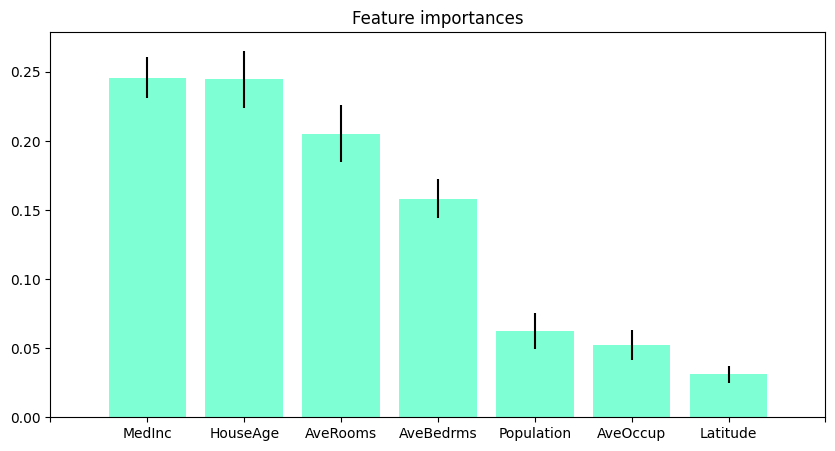

In [46]:
# get the estimates of feature importances
importances = model.feature_importances_
# calculate the std:
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# This part will be used to make nice x-axis labels
# (we'll tell matplotlib to convert numeric feature
# index to a text label):
from matplotlib.ticker import FuncFormatter, MaxNLocator
def format_fn(tick_val, tick_pos):
    if int(tick_val) in range(len(importances)):
        return data.columns[int(tick_val)]
    else:
        return ''

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Feature importances")
ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.bar(range(len(importances)), importances[indices],
       color="aquamarine", yerr=std[indices], align="center")
ax.set_xlim([-1, len(importances)])
plt.show();

## Bonus part 2: visualizing a tree

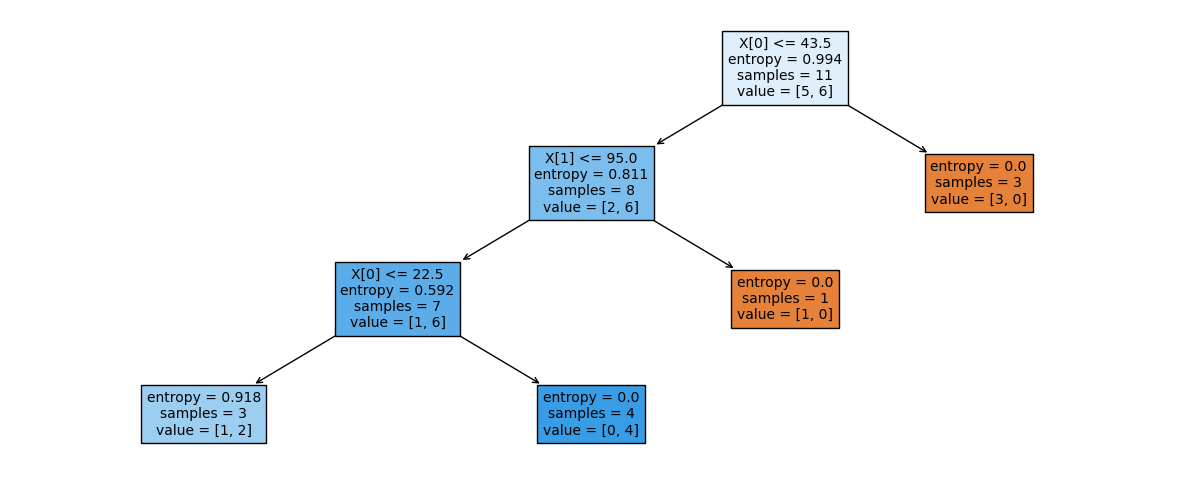

In [ ]:
from sklearn.tree import plot_tree

fig=plt.figure(figsize=(15, 6))
plot_tree(age_sal_tree, max_depth=3, fontsize=10, filled=True)
fig.savefig('img.jpeg', dpi=200) 


### Hyperparameters optimization

There's many hyperparameter optimization methods, many implemented in the [scikit-optimize](https://scikit-optimize.github.io/) package, e.g. bayessian optimization with gaussian process ([see this link](https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html) for a nice tutorial).